In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import math
import shapely.geometry
import pandas as pd
from geopy.distance import great_circle
from t4gpd.morph.geoProcesses.SkyViewFactorOnTopOfRoof import SkyViewFactorOnTopOfRoof
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.sun.DateTimeGenerator import DateTimeGenerator
from t4gpd.sun.geoProcesses.SunshineDurationOnTopOfRoof import SunshineDurationOnTopOfRoof
from datetime import datetime, timezone
import numpy

In [2]:
Zone = gpd.read_file('data\Part_Dieu_buffer_1km.shp')
ZoneMoyenne = gpd.read_file('data\ZoneMoyenne.shp')
ZoneReduite = gpd.read_file('data\zone.shp')

In [3]:
ToitsPlats = gpd.read_file('data\ToitsPlatsPartDieu.shp',mask = Zone)

C:\Users\maison\miniconda3\envs\gpd\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [4]:
Toits = gpd.read_file('data\ToitsPartDieu.shp', mask = Zone)

In [178]:
ToitsPlats['geometry']=ToitsPlats['geometry'].buffer(-0.5)

In [179]:
ToitsPlats['surf']=ToitsPlats['geometry'].area
ToitsPlats = ToitsPlats[ToitsPlats.surf > 50]

In [180]:
ToitsPlats['perimetre']=ToitsPlats['geometry'].length

In [181]:
ToitsPlats['RER']=(ToitsPlats['surf'])/(ToitsPlats['surf']+(ToitsPlats['perimetre']*ToitsPlats['htotale']))

In [182]:
a = 0.03608 
b = 0.3691 
c = 1.561 
d = -0.2148 
e = 3.949 
f = -3.852

In [183]:
ToitsPlats['ET']=(a+b*ToitsPlats['RER']+c*pow(ToitsPlats['RER'],2)+e*pow(ToitsPlats['RER'],3)+f*pow(ToitsPlats['RER'],4))*numpy.exp(d*ToitsPlats['htotale'])

In [184]:
ToitsPlats2 = ToitsPlats.copy()

In [186]:
ToitsPlats2['geometry']=ToitsPlats2['geometry'].centroid
Toits['geometry']=Toits['geometry'].centroid

<ipython-input-186-9984c7c1924a>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Toits['geometry']=Toits['geometry'].centroid


In [189]:
ToitsPlats2.to_crs(epsg=4326, inplace=True)
Toits.to_crs(epsg=4326, inplace=True)

In [190]:
ListSurfacesPlanesAutour=[]
for index2, row2 in ToitsPlats2.iterrows():
    if not row2['geometry'].is_empty :
        S=0
        for index, row in ToitsPlats2.iterrows():
            if not row['geometry'].is_empty :
                if great_circle(row2['geometry'].coords[0],row['geometry'].coords[0]).m < 200 :
                    S += row['surf']
        ListSurfacesPlanesAutour.append(S)

In [196]:
ListSurfacesAutour=[]
for index2, row2 in ToitsPlats2.iterrows():
    if not row2['geometry'].is_empty :
        S=0
        for index, row in Toits.iterrows():
            if not row['geometry'].is_empty :
                if great_circle(row2['geometry'].coords[0],row['geometry'].coords[0]).m < 200 :
                    S += row['surface']
        ListSurfacesAutour.append(S)

In [197]:
ToitsPlats2['surf_plane_autour']=ListSurfacesPlanesAutour

In [198]:
ToitsPlats2['surf_totale_autour']=ListSurfacesAutour

In [199]:
ToitsPlats2['GRCF']=ToitsPlats2['surf_plane_autour']/ToitsPlats2['surf_totale_autour']

In [200]:
ToitsPlats2['RICU']=(0.5*ToitsPlats2['GRCF'])/0.9

In [206]:
ToitsPlats2['geometry']=ToitsPlats['geometry']

In [207]:
svfRoof = SkyViewFactorOnTopOfRoof(ToitsPlats2, nRays=16, maxRayLen=100.0, elevationFieldname='htotale')

SVF calculation method: Bernard et al. (2018), nRays = 16, maxRayLen = 100.0


In [208]:
ToitsPlats2.reset_index(drop = True, inplace = True)

In [209]:
result1 = STGeoProcess(svfRoof, ToitsPlats2).run()

In [210]:
result1['geometry']=ToitsPlats2['geometry']

In [211]:
result1['SVV'] = result1['surf']*(1-result1['svf_roof'])

In [212]:
result1.to_crs(epsg=4326, inplace = True)

In [213]:
dt = [datetime(2021, _month, 21, _hour, minute=0, tzinfo=timezone.utc) for _hour in range(9,19) for _month in range(1,13)]

In [214]:
op = SunshineDurationOnTopOfRoof(result1, 'htotale', dt)

In [215]:
result2 = STGeoProcess(op, result1).run()

In [216]:
result2.to_crs(epsg=4326, inplace = True)

In [222]:
result3 = result2.copy()

In [223]:
maxET = result3['ET'].max()
maxRICU = result3['RICU'].max()
maxSVV = result3['SVV'].max()
maxSUNRATIO = result3['sun_ratio'].max()

In [224]:
result3['ET_n'] = result3['ET']/maxET
result3['RICU_n'] = result3['RICU']/maxRICU
result3['SVV_n'] = result3['SVV']/maxSVV
result3['SUNRATIO_n'] = result3['sun_ratio']/maxSUNRATIO

<AxesSubplot:title={'center':'Ensoleillement (normalisé)'}>

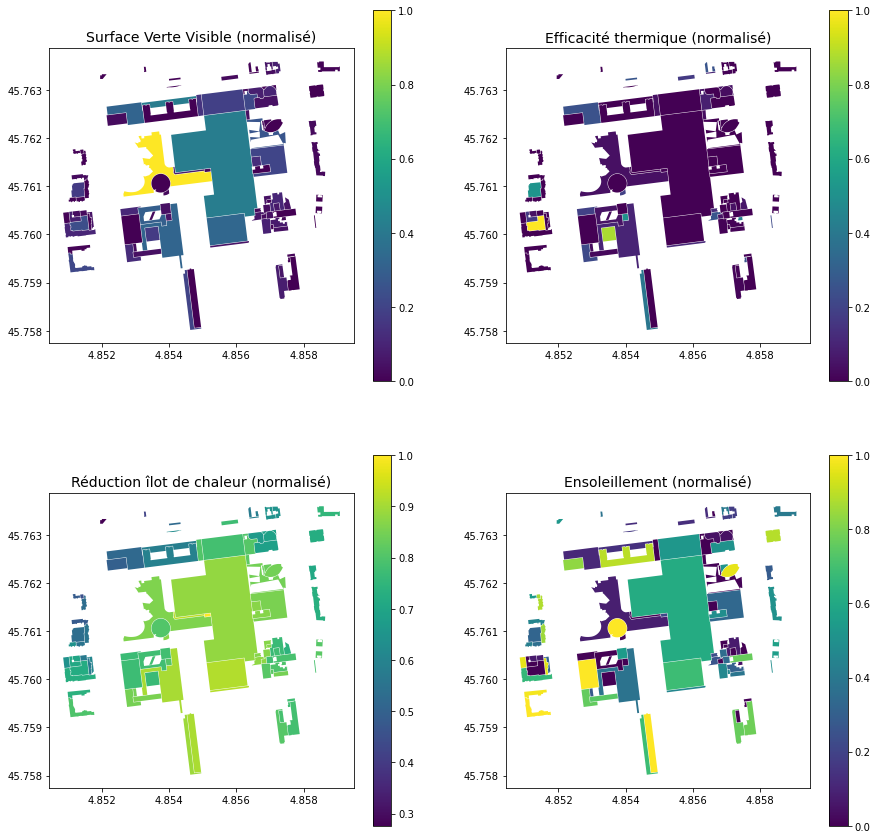

In [226]:
fig , axs = plt.subplots(2,2,figsize=(15,15))
axs[0,0].set_title('Surface Verte Visible (normalisé)', fontsize=14)
axs[0,1].set_title('Efficacité thermique (normalisé)', fontsize=14)
axs[1,0].set_title('Réduction îlot de chaleur (normalisé)', fontsize=14)
axs[1,1].set_title('Ensoleillement (normalisé)', fontsize=14)
result3.plot(ax=axs[0,0], column='SVV_n', cmap='viridis', legend=True)
result3.plot(ax=axs[0,1], column='ET_n', cmap='viridis', legend=True)
result3.plot(ax=axs[1,0], column='RICU_n', cmap='viridis', legend=True)
result3.plot(ax=axs[1,1], column='SUNRATIO_n', cmap='viridis', legend=True)

In [239]:
ListIGVG = []
for index, row in result3.iterrows():
    if row['SUNRATIO_n'] < 0.1 :
        ListIGVG.append(0)
    else :
        ListIGVG.append(row['SUNRATIO_n']*(0.35*row['SVV_n']+0.5*row['RICU_n']+0.15*row['ET_n']))

In [241]:
result3['IGVG']=ListIGVG

<AxesSubplot:>

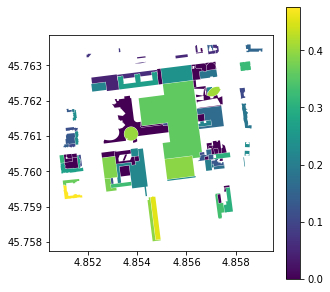

In [244]:
_, basemap = plt.subplots(figsize =(5,5))
result3.plot(ax=basemap, column='IGVG', legend = True)

In [245]:
result3.to_file('produced_data/INDICATEURS_TOITS.shp',driver ='ESRI Shapefile')